# Imports

In [1]:
import pandas as pd
from feature_engine.timeseries.forecasting import LagFeatures

from _config import PKL_PROCESSED_STEP1_DTU_SOLAR_STATION, PKL_PROCESSED_STEP2_DTU_SOLAR_STATION

# Load Config

In [2]:
import json
from dataclasses import dataclass
from typing import Optional


@dataclass
class TargetVariables:
    name: str

    @staticmethod
    def from_dict(data: dict) -> 'TargetVariables':
        return TargetVariables(**data)


@dataclass
class FeatureVariables:
    name: str
    lag: Optional[int] = None

    @staticmethod
    def from_dict(data: dict) -> 'FeatureVariables':
        return FeatureVariables(**data)


@dataclass
class MyConfig:
    name: str
    description: int
    target_variables: list[TargetVariables]
    features: list[FeatureVariables]

    @staticmethod
    def from_dict(data: dict) -> 'MyConfig':
        data['target_variables'] = [TargetVariables.from_dict(tv) for tv in data['target_variables']]
        data['features'] = [FeatureVariables.from_dict(f) for f in data['features']]
        return MyConfig(**data)


with open('config.json', 'r') as file:
    data = json.load(file)

my_config = MyConfig.from_dict(data)

print(my_config)


MyConfig(name='solar-irradiance', description='Forecasting solar irradiance using weather data', target_variables=[TargetVariables(name='DHI')], features=[FeatureVariables(name='air_pressure', lag=[60, 1440]), FeatureVariables(name='air_temperature', lag=[60, 1440]), FeatureVariables(name='rain_duration', lag=[60, 1440]), FeatureVariables(name='rain_intensity', lag=[60, 1440]), FeatureVariables(name='relative_humidity', lag=[60, 1440]), FeatureVariables(name='solar_altitude', lag=[60, 1440]), FeatureVariables(name='wind_dir_avg', lag=[60, 1440]), FeatureVariables(name='wind_speed_avg', lag=[60, 1440])])


# Load (Preprocessed Step 1) DTU Solar Station data

In [5]:
df = pd.read_pickle(PKL_PROCESSED_STEP1_DTU_SOLAR_STATION)
df = df[sorted(df.columns)]

print(df.shape)
print(df.info())
df.head()

(5260805, 10)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5260805 entries, 2015-01-01 00:00:00 to 2025-01-01 08:04:00
Freq: min
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   DHI                float64
 1   DNI                float64
 2   air_pressure       float64
 3   air_temperature    float64
 4   rain_duration      float64
 5   rain_intensity     float64
 6   relative_humidity  float64
 7   solar_altitude     float64
 8   wind_dir_avg       float64
 9   wind_speed_avg     float64
dtypes: float64(10)
memory usage: 441.5 MB
None


,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# # find nan values
# mask = df.isna().any(axis=1)
# # set all nan values to 0
# df.fillna(0, inplace=True)

# Lag Features
In order to predict the future values of the target variables, we need to create lagged features. This is done by shifting the values of the features by a certain number of time steps. In this case, we are shifting the values by 60 time steps (1 hour) to predict the future values of the target variables.

In [6]:
TARGETS = [x.name for x in my_config.target_variables]
FEATURES = [x.name for x in my_config.features]
TARGETS, FEATURES

(['DHI'],
 ['air_pressure',
  'air_temperature',
  'rain_duration',
  'rain_intensity',
  'relative_humidity',
  'solar_altitude',
  'wind_dir_avg',
  'wind_speed_avg'])

In [7]:
df_lagged = df.copy()

In [8]:
TARGETS = [x.name for x in my_config.target_variables]
FEATURES = [x.name for x in my_config.features]

for feature in my_config.features:
    if feature.lag is not None:
        for lag in feature.lag:
            df_lagged[f'{feature.name}_lag_{lag}'] = df[feature.name].shift(lag)

In [9]:
df_lagged

,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg,...,rain_intensity_lag_60,rain_intensity_lag_1440,relative_humidity_lag_60,relative_humidity_lag_1440,solar_altitude_lag_60,solar_altitude_lag_1440,wind_dir_avg_lag_60,wind_dir_avg_lag_1440,wind_speed_avg_lag_60,wind_speed_avg_lag_1440
2015-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:01:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:02:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:03:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 00:04:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 08:00:00,0.0,0.0,990.0,8.3,50.0,0.3,85.5,1.553152,235.0,5.2,...,0.1,0.0,85.4,85.9,-5.145025,1.527402,245.0,265.0,6.4,0.2
2025-01-01 08:01:00,0.0,0.0,989.8,8.3,60.0,0.4,85.6,1.641343,227.0,9.3,...,0.2,0.0,85.4,85.9,-5.027539,1.615278,244.0,204.0,4.9,0.7
2025-01-01 08:02:00,0.0,0.0,990.0,8.3,40.0,0.5,85.5,1.729506,280.0,2.1,...,0.4,0.0,85.4,86.0,-4.910267,1.703127,227.0,114.0,8.9,0.4
2025-01-01 08:03:00,0.0,0.0,989.9,8.3,50.0,0.5,85.6,1.817622,260.0,7.6,...,0.3,0.0,85.4,86.0,-4.793205,1.790932,235.0,72.0,7.6,0.2


In [9]:
# remove the masked rows from the original dataframe
df_lagged = df_lagged[~mask].copy()
df_lagged.dropna(inplace=True)  # Drop any remaining NaN values.
df_lagged.shape

(2460051, 26)

Visualizing that the lagged features are correctly created. \
We see that originally at time t, the df dataframe has the values for the features. \
When looking at the lagged dataframe, we see that the values at time t are now at time t+60 and that the target values are still at time t.

In [10]:
display(df.loc['2022-06-12T11:00:00':'2022-06-12T15:00:00'][:5])
display(df_lagged.loc['2022-06-12T11:00:00':'2022-06-12T15:00:00'][60:65])

,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg
2022-06-12 11:00:00,107.40,0.0,1012.0,18.6,10.0,0.0,55.9,57.333589,242.0,3.9
2022-06-12 11:01:00,99.50,0.0,1012.0,18.5,40.0,3.1,55.9,57.343302,238.0,2.9
2022-06-12 11:02:00,94.41,0.0,1012.0,18.5,60.0,3.3,56.7,57.351976,236.0,3.3
2022-06-12 11:03:00,90.15,0.0,1012.0,18.4,60.0,11.1,57.7,57.359607,258.0,4.1
2022-06-12 11:04:00,102.10,0.0,1012.0,18.3,60.0,25.0,58.0,57.366196,241.0,4.7


,DHI,DNI,air_pressure,air_temperature,rain_duration,rain_intensity,relative_humidity,solar_altitude,wind_dir_avg,wind_speed_avg,...,rain_intensity_lag_60,rain_intensity_lag_1440,relative_humidity_lag_60,relative_humidity_lag_1440,solar_altitude_lag_60,solar_altitude_lag_1440,wind_dir_avg_lag_60,wind_dir_avg_lag_1440,wind_speed_avg_lag_60,wind_speed_avg_lag_1440
2022-06-12 12:00:00,286.2,630.421623,1011.0,18.9,0.0,0.0,55.3,56.095320,238.0,4.4,...,0.0,0.0,55.9,59.1,57.333589,56.022146,242.0,152.0,3.9,1.2
2022-06-12 12:01:00,270.7,630.823404,1011.0,19.0,0.0,0.0,55.5,56.044583,263.0,6.5,...,3.1,0.0,55.9,58.1,57.343302,55.971283,238.0,183.0,2.9,3.9
2022-06-12 12:02:00,258.6,698.328352,1011.0,19.0,0.0,0.0,55.9,55.992930,227.0,3.9,...,3.3,0.0,56.7,58.9,57.351976,55.919507,236.0,177.0,3.3,1.1
2022-06-12 12:03:00,252.3,779.535469,1011.0,19.0,0.0,0.0,55.2,55.940367,236.0,3.2,...,11.1,0.0,57.7,58.4,57.359607,55.866822,258.0,207.0,4.1,2.2
2022-06-12 12:04:00,244.9,620.329962,1011.0,19.0,0.0,0.0,56.2,55.886898,328.0,1.8,...,25.0,0.0,58.0,57.9,57.366196,55.813232,241.0,176.0,4.7,2.4


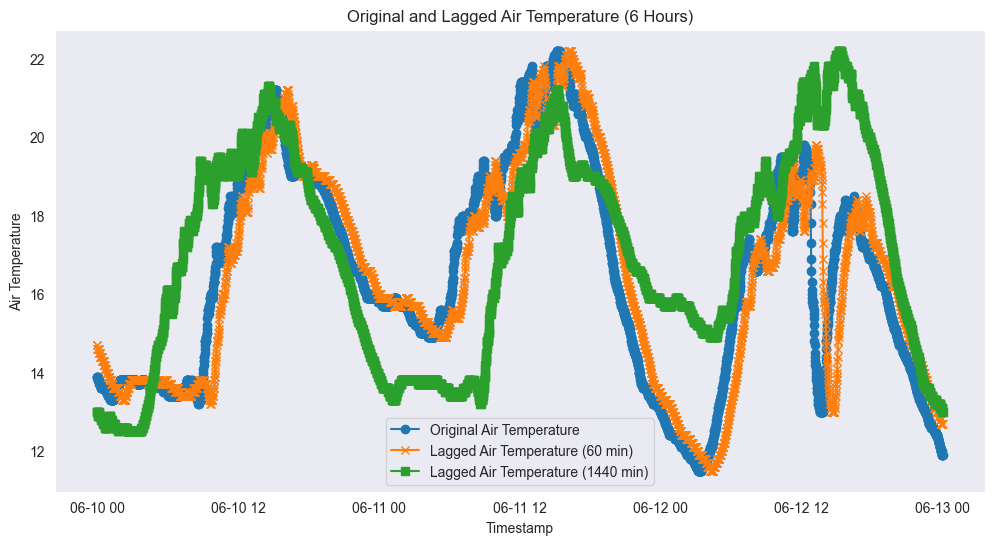

In [11]:
import matplotlib.pyplot as plt

# Select a 6-hour range of data
start_time = '2022-06-10'
end_time = '2022-06-12'

# Extract the original and lagged air temperature
original_air_temp = df.loc[start_time:end_time, 'air_temperature']
lagged_air_temp = df_lagged.loc[start_time:end_time, 'air_temperature_lag_60']
lagged_air_temp_1440 = df_lagged.loc[start_time:end_time, 'air_temperature_lag_1440']

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(original_air_temp, label='Original Air Temperature', marker='o')
plt.plot(lagged_air_temp, label='Lagged Air Temperature (60 min)', marker='x')
plt.plot(lagged_air_temp_1440, label='Lagged Air Temperature (1440 min)', marker='s')
plt.title('Original and Lagged Air Temperature (6 Hours)')
plt.xlabel('Timestamp')
plt.ylabel('Air Temperature')
plt.legend()
plt.grid()
plt.show()

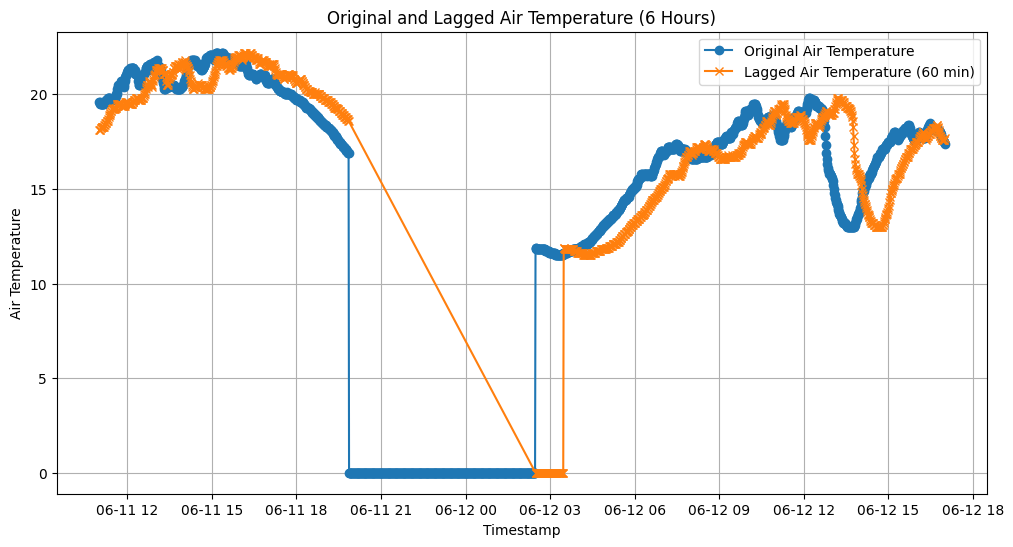

In [34]:
import matplotlib.pyplot as plt

# Select a 6-hour range of data
start_time = '2022-06-11T11:00:00'
end_time = '2022-06-12T17:00:00'

# Extract the original and lagged air temperature
original_air_temp = df.loc[start_time:end_time, 'air_temperature']
lagged_air_temp = df_lagged.loc[start_time:end_time, 'air_temperature_lag_60']

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(original_air_temp, label='Original Air Temperature', marker='o')
plt.plot(lagged_air_temp, label='Lagged Air Temperature (60 min)', marker='x')
plt.title('Original and Lagged Air Temperature (6 Hours)')
plt.xlabel('Timestamp')
plt.ylabel('Air Temperature')
plt.legend()
plt.grid()
plt.show()

In [35]:
df_lagged.to_pickle(PKL_PROCESSED_STEP2_DTU_SOLAR_STATION)

In [36]:
df_lagged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2460682 entries, 2015-03-12 06:36:00 to 2025-01-01 08:04:00
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   DHI                       float64
 1   DNI                       float64
 2   air_pressure              float64
 3   air_pressure_lag_60       float64
 4   air_temperature           float64
 5   air_temperature_lag_60    float64
 6   rain_duration             float64
 7   rain_duration_lag_60      float64
 8   rain_intensity            float64
 9   rain_intensity_lag_60     float64
 10  relative_humidity         float64
 11  relative_humidity_lag_60  float64
 12  solar_altitude            float64
 13  solar_altitude_lag_60     float64
 14  wind_dir_avg              float64
 15  wind_dir_avg_lag_60       float64
 16  wind_speed_avg            float64
 17  wind_speed_avg_lag_60     float64
dtypes: float64(18)
memory usage: 356.7 MB
